# Combining Different Models for Ensemble Learning

https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch07/ch07.ipynb

In [25]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)


*Note*:  For historical reasons, Python 2.7's math.ceil returns a float instead of an integer like in Python 3.x. Although Although this book was written for Python >3.4, let's make it compatible to Python 2.7 by casting it to an it explicitely:



In [2]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)


In [3]:
ensemble_error(n_classifier=11, error=0.25)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  import sys


0.03432750701904297

In [4]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  import sys


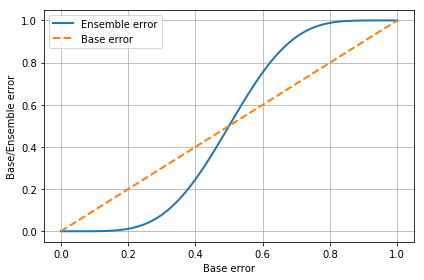

In [6]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
# plt.savefig('./figures/ensemble_err.png', dpi=300)
plt.show()


# Classifying Iris Flowers Using Different Classification Models
For a simple example, let us use three different classification models to classify the samples in the Iris dataset: Logistic regression, a naive Bayes classifier with a Gaussian kernel, and a random forest classifier -- an ensemble method itself. At this point, let's not worry about preprocessing the data and training and test sets. Also, we will only use 2 feature columns (sepal width and petal height) to make the classification problem harder.



In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target


In [9]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import sklearn

np.random.seed(123)

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], ['Logistic Regression', 'Random Forest', 'naive Bayes']):

    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: ", scores.mean(), scores.std(), label)


5-fold cross validation:

Accuracy:  0.9 0.04714045207910316 Logistic Regression
Accuracy:  0.9133333333333334 0.04521553322083511 Random Forest
Accuracy:  0.9133333333333334 0.039999999999999994 naive Bayes


/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: 

# Implementing a simple majority vote classifier

Now, we will implement a simple EnsembleClassifier class that allows us to combine the three different classifiers. We define a predict method that let's us simply take the majority rule of the predictions by the classifiers. E.g., if the prediction for a sample is

- classifier 1 -> class 1
- classifier 2 -> class 1
- classifier 3 -> class 2
we would classify the sample as "class 1."

Furthermore, we add a weights parameter, which let's us assign a specific weight to each classifier. In order to work with the weights, we collect the predicted class probabilities for each classifier, multiply it by the classifier weight, and take the average. Based on these weighted average probabilties, we can then assign the class label.

To illustrate this with a simple example, let's assume we have 3 classifiers and a 3-class classification problems where we assign equal weights to all classifiers (the default): w1=1, w2=1, w3=1.

The weighted average probabilities for a sample would then be calculated as follows:

classifier	| class 1	| class 2	| class 3
------------|------------|------------|---------:
classifier 1	| w1 * 0.2	| w1 * 0.5	| w1 * 0.3
classifier 2	| w2 * 0.6	| w2 * 0.3	| w2 * 0.1
classifier 3	| w3 * 0.3	| w3 * 0.4	| w3 * 0.3
weighted average	| 0.37	| 0.4	| 0.3
We can see in the table above that class 2 has the highest weighted average probability, thus we classify the sample as class 2.

Now, let's put it into code and apply it to our Iris classification.




In [28]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))


1

In [29]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p


array([0.58, 0.42])

In [27]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [31]:
np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy:",scores.mean(), scores.std(), label)


Accuracy: 0.9 0.04714045207910316 Logistic Regression
Accuracy: 0.9133333333333334 0.04521553322083511 Random Forest
Accuracy: 0.9133333333333334 0.039999999999999994 naive Bayes
Accuracy: 0.9533333333333334 0.03399346342395189 Ensemble


/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: 

## Combining different algorithms for classification with majority vote


In [33]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1)


In [40]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10 fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = model_selection.cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC", (scores.mean(), scores.std(), label))


10 fold cross validation:

ROC AUC (0.9166666666666667, 0.2006932429798716, 'Logistic Regression')
ROC AUC (0.9166666666666667, 0.15365907428821476, 'Decision Tree')
ROC AUC (0.9333333333333333, 0.10408329997330663, 'KNN')


/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

In [41]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))


ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anniee/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec